In [231]:
from bert_embedding import BertEmbedding
#from keras.preprocessing.text import Tokenizer
import numpy as np
import matplotlib.pyplot as plt
import nltk
from string import punctuation
from sklearn.decomposition import PCA
import pandas as pd
from scipy import spatial

In [248]:
topics = {
  "mk": "Musculoskeletal Radiology",
  "ct": "Computed Tomography",
  "br": "Breast Imaging",
  "gu": "Geritourinary Radiology",
  "us": "Ultrasound",
  "ch": "Chest Radiology",
  "ir": "Interventional Radiology",
}

In [5]:
def read_topics(index):
    """
    read given index of data
    """
    if index in topics:
        data = np.array(pd.read_excel("database100_preprocessed.xlsx", sheet_name=index).abstract)

        final_corpus = [sentence for sentence in data if sentence.strip() !='']

        word_punctuation_tokenizer = nltk.WordPunctTokenizer()
        word_tokenized_corpus = [word_punctuation_tokenizer.tokenize(abstract) for abstract in final_corpus]

        return word_tokenized_corpus

In [10]:
def read_abstracts(index):
    
    if index in topics:
        data = np.array(pd.read_excel("database100_preprocessed.xlsx", sheet_name=index).abstract)
        
        string_of_abstracts = ""

        for abstract in data:
            string_of_abstracts += abstract
            string_of_abstracts += "\n"
        
        return string_of_abstracts

In [270]:
pca = PCA(n_components=2)

be_topic_results = []

pca_abstracts = []

for topic in topics:
    abstracts = read_abstracts(topic).split("\n")
    topic_title = ""
    for word in topics[topic].lower():
        topic_title += word
    topic_title += "\n"
    topic_title = topic_title.split("\n")
    be_model = BertEmbedding(model='bert_24_1024_16')
    be_abst_result = be_model(abstracts)
    be_topic_result = be_model(topic_title)
    
    # add the be_result of the topic to a list
    be_topic_result = be_topic_result[:-1]
    be_topic_results.append(be_topic_result)
    
    
    # for some reason bert-embedding
    # returns an empty tuple in the last index
    # so it needs to be removed
    be_abst_result = be_abst_result[:-1]
    
    
    #for word in be_topic_result:
        
    
    

    # bert-embedding returns 768 values
    # for each word so we
    # add them all into a list
    abstract_values = []
    for abstract in be_abst_result:
        word_values = []
        for word in abstract[1]:
            word_values.append(word)
        
        #calculate means for each abstract
        mean = np.mean(word_values, axis=0)
        abstract_values.append(mean)
    
    # perfrorm PCA for all the abstracts in topic
    two_dim_abstracts = pca.fit_transform(abstract_values)
    pca_abstracts.append(two_dim_abstracts)

In [271]:
# calculate means for each topic

topic_values = []
for topic in be_topic_results:
    
    word_values = []
    
    for word in topic[0][1]:
        word_values.append(word)
        
    mean = np.mean(word_values, axis=0)
    topic_values.append(mean)
    

pca_topics = pca.fit_transform(topic_values)
    

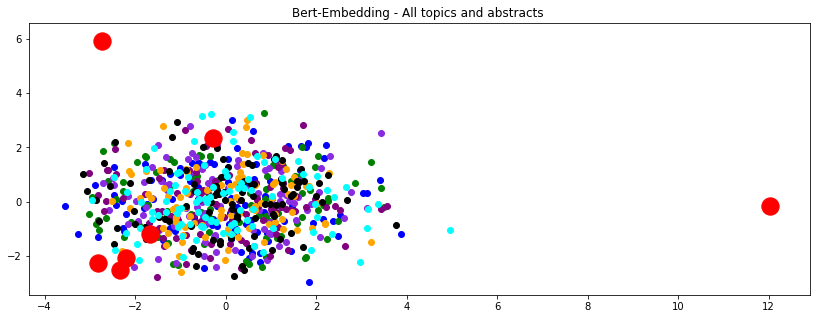

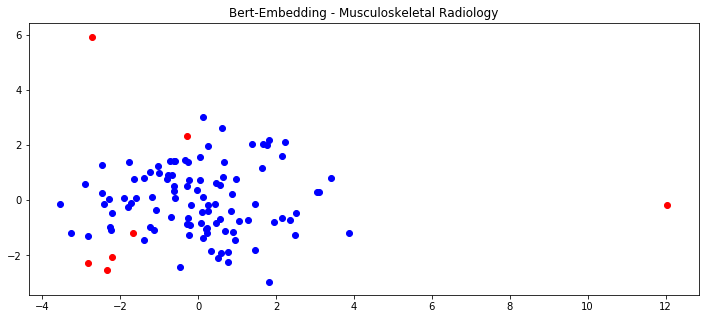

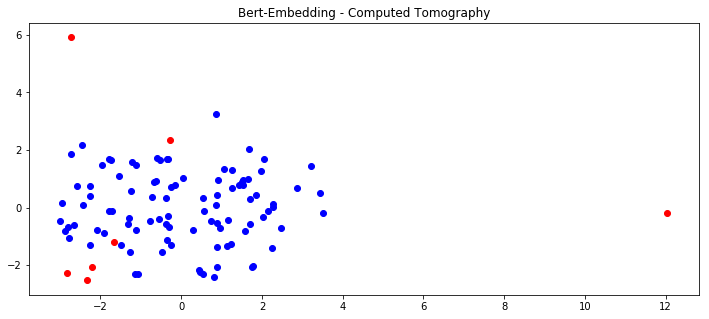

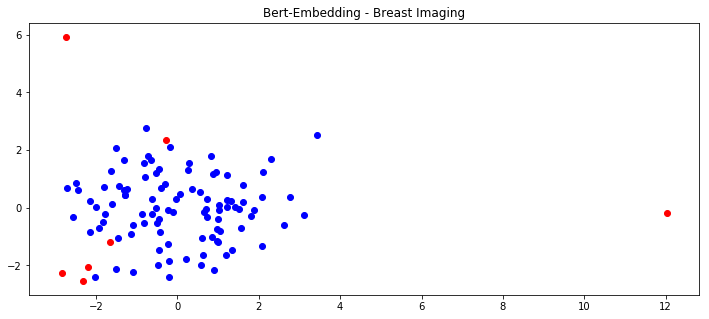

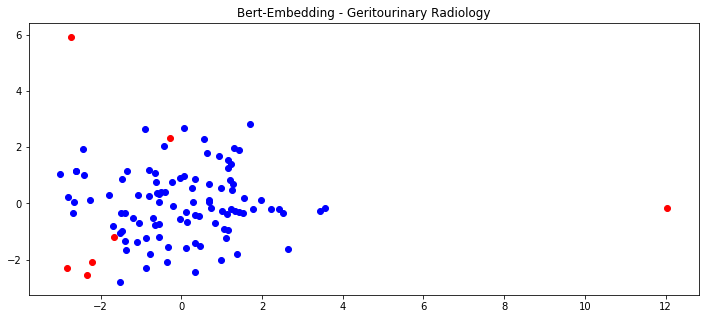

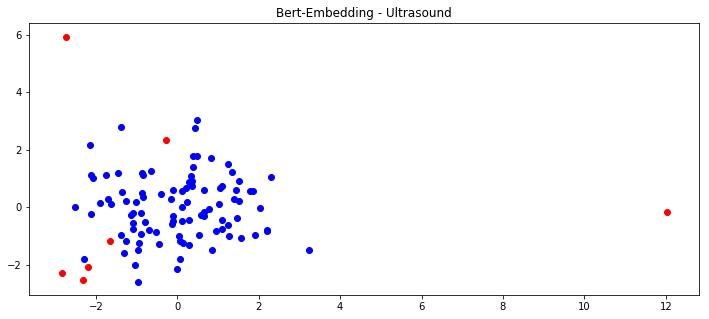

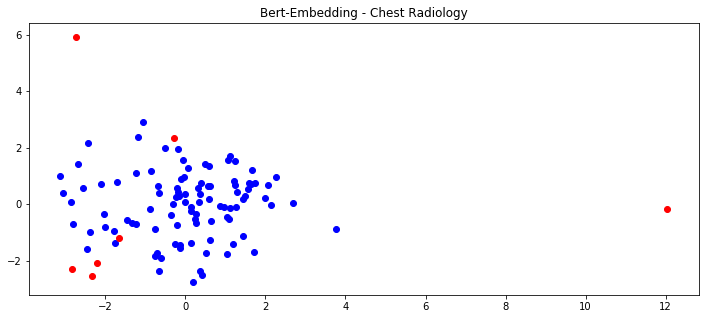

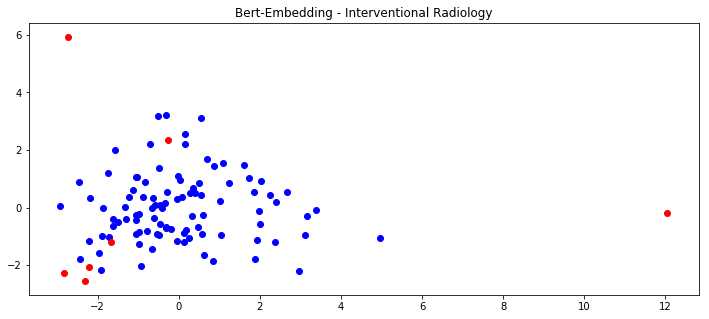

In [272]:
# visualize all the topics and abstracts in the same plot
plt.figure(figsize=(14,5))
plt.scatter(pca_abstracts[0][:, 0], pca_abstracts[0][:, 1], c='blue')
plt.scatter(pca_abstracts[1][:, 0], pca_abstracts[1][:, 1], c='green')
plt.scatter(pca_abstracts[2][:, 0], pca_abstracts[2][:, 1], c='blueviolet')
plt.scatter(pca_abstracts[3][:, 0], pca_abstracts[3][:, 1], c='purple')
plt.scatter(pca_abstracts[4][:, 0], pca_abstracts[4][:, 1], c='orange')
plt.scatter(pca_abstracts[5][:, 0], pca_abstracts[5][:, 1], c='black')
plt.scatter(pca_abstracts[6][:, 0], pca_abstracts[6][:, 1], c='cyan')
for topic in pca_topics:
    plt.scatter(topic[0], topic[1], c='red', s=300)
plt.title("Bert-Embedding - All topics and abstracts ")

# visualize all the topics and all abstracts from one topic in one plot
for i, topic in enumerate(topics):
    plt.figure(figsize=(12, 5))
    plt.scatter(pca_abstracts[i][:, 0], pca_abstracts[i][:, 1], c='blue')
    for topic1 in pca_topics:
        plt.scatter(topic1[0], topic1[1], c='red')
    plt.title("Bert-Embedding - " + topics[topic])

In [273]:
def spatial_distance(vector1, vector2):
    return spatial.distance.euclidean(vector1, vector2)

def predict_correct_class(a_pca_vectors, topic_pca_vectors, correct_class):
    abstracts = []
    for i, vector in enumerate(a_pca_vectors):
        distances = []
        for topic in topic_pca_vectors:
            # euclidean distance between abstract and points
            distances.append(spatial_distance(vector,topic))
        abstracts.append(distances)
    right_wrong = [0,0]
    for distance in abstracts:
        if np.argmin(distance) == correct_class:
            right_wrong[0] += 1
        else: right_wrong[1] += 1
    return right_wrong

In [279]:
# Calculate euclidean distances to determine a "class" or topic
# for each abstract
# 
# Example:
# Right-Wrong: [40, 50]
# means that 40 abstracts would be classified in correct topic
# and 50 in wrong topic
# which equals to 40/90 = 0.44 = 44% classification success rate

right_wrongs = []
for i, pca_abstract in enumerate(pca_abstracts):
    right_wrong = predict_correct_class(pca_abstract, pca_topics, i)
    right_wrong.append(i)
    right_wrongs.append(right_wrong)

accuracies = []
for i, topic in enumerate(topics):
    if i == right_wrongs[i][2]:
        print("\n" + topics[topic])
        print("Right-Wrong ", right_wrongs[i][:-1])
        print("Accuracy: ", round(right_wrongs[i][0]/(right_wrongs[i][0]+right_wrongs[i][1]), 4))
        accuracies.append(right_wrongs[i][0]/(right_wrongs[i][0]+right_wrongs[i][1]))

print("\nMean of accuracies: ", round(np.mean(accuracies), 4))


Musculoskeletal Radiology
Right-Wrong  [0, 100]
Accuracy:  0.0

Computed Tomography
Right-Wrong  [0, 96]
Accuracy:  0.0

Breast Imaging
Right-Wrong  [43, 55]
Accuracy:  0.4388

Geritourinary Radiology
Right-Wrong  [1, 98]
Accuracy:  0.0101

Ultrasound
Right-Wrong  [0, 96]
Accuracy:  0.0

Chest Radiology
Right-Wrong  [48, 51]
Accuracy:  0.4848

Interventional Radiology
Right-Wrong  [0, 96]
Accuracy:  0.0

Mean of accuracies:  0.1334
